# Twitter Sentiment Analysis by Pre-processing data using Artificial Intelligence

## UTILS

In [1]:
import sys
import pickle
import random


def file_to_wordset(filename):
    ''' Converts a file with a word per line to a Python set '''
    words = []
    with open(filename, 'r') as f:
        for line in f:
            words.append(line.strip())
    return set(words)


def write_status(i, total):
    ''' Writes status of a process to console '''
    sys.stdout.write('\r')
    sys.stdout.write('Processing %d/%d' % (i, total))
    sys.stdout.flush()

def save_results_to_csv(results, csv_file):
    ''' Save list of type [(tweet_id, positive)] to csv in Kaggle format '''
    with open(csv_file, 'w') as csv:
        csv.write('id,prediction\n')
        for tweet_id, pred in results:
            csv.write(tweet_id)
            csv.write(',')
            csv.write(str(pred))
            csv.write('\n')


def top_n_words(pkl_file_name, N, shift=0):
    """
    Returns a dictionary of form {word:rank} of top N words from a pickle
    file which has a nltk FreqDist object generated by stats.py
    Args:
        pkl_file_name (str): Name of pickle file
        N (int): The number of words to get
        shift: amount to shift the rank from 0.
    Returns:
        dict: Of form {word:rank}
    """
    with open(pkl_file_name, 'rb') as pkl_file:
        freq_dist = pickle.load(pkl_file)
    most_common = freq_dist.most_common(N)
    words = {p[0]: i + shift for i, p in enumerate(most_common)}
    return words


def top_n_bigrams(pkl_file_name, N, shift=0):
    """
    Returns a dictionary of form {bigram:rank} of top N bigrams from a pickle
    file which has a Counter object generated by stats.py
    Args:
        pkl_file_name (str): Name of pickle file
        N (int): The number of bigrams to get
        shift: amount to shift the rank from 0.
    Returns:
        dict: Of form {bigram:rank}
    """
    with open(pkl_file_name, 'rb') as pkl_file:
        freq_dist = pickle.load(pkl_file)
    most_common = freq_dist.most_common(N)
    bigrams = {p[0]: i for i, p in enumerate(most_common)}
    return bigrams


def split_data(tweets, validation_split=0.1):
    """Split the data into training and validation sets
    Args:
        tweets (list): list of tuples
        validation_split (float, optional): validation split %
    Returns:
        (list, list): training-set, validation-set
    """
    index = int((1 - validation_split) * len(tweets))
    random.shuffle(tweets)
    return tweets[:index], tweets[index:]

# PREPROCESS

In [3]:
import re
import sys

from nltk.stem.porter import PorterStemmer


def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)

    return ' '.join(processed_tweet)


def preprocess_csv(csv_file_name, processed_file_name, test_file=True):
    save_to_file = open(processed_file_name, 'w')

    with open(csv_file_name, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        #print(lines[:100])
        for i, line in enumerate(lines):
            #print('helllllllllllllllllloooo',i,line)
            tweet_id = line[:line.find(',')]
            #print(tweet_id)
            if not test_file:
                line = line[1 + line.find(','):]
                #print('undar',line)
                positive = int(line[:line.find(',')])
            line = line[1 + line.find(','):]
            tweet = line
            processed_tweet = preprocess_tweet(tweet)
            if not test_file:
                save_to_file.write('%s,%d,%s\n' %
                                   (tweet_id, positive, processed_tweet))
            else:
                save_to_file.write('%s,%s\n' %
                                   (tweet_id, processed_tweet))
            write_status(i + 1, total)
    save_to_file.close()
    print ('\nSaved processed tweets to: %s' % processed_file_name)
    return processed_file_name


if __name__ == '__main__':
    if len(sys.argv) != 2:
        print ('Usage: python preprocess.py <raw-CSV>')
        exit()
    use_stemmer = False
    csv_file_name = 'C:/Users/Het Patel/Pictures/AI/test.csv'
    processed_file_name = sys.argv[1][:-4] + 'test-processed.csv'
    if use_stemmer:
        porter_stemmer = PorterStemmer()
        processed_file_name = sys.argv[1][:-4] + '-processed-stemmed.csv'
    preprocess_csv(csv_file_name, processed_file_name, test_file=True)

Usage: python preprocess.py <raw-CSV>


# STATS

In [2]:
from nltk import FreqDist
import pickle
import sys
#from utils import write_status
from collections import Counter


# Takes in a preprocessed CSV file and gives statistics
# Writes the frequency distribution of words and bigrams
# to pickle files.


def analyze_tweet(tweet):
    result = {}
    result['MENTIONS'] = tweet.count('USER_MENTION')
    result['URLS'] = tweet.count('URL')
    result['POS_EMOS'] = tweet.count('EMO_POS')
    result['NEG_EMOS'] = tweet.count('EMO_NEG')
    tweet = tweet.replace('USER_MENTION', '').replace(
        'URL', '')
    words = tweet.split()
    result['WORDS'] = len(words)
    bigrams = get_bigrams(words)
    result['BIGRAMS'] = len(bigrams)
    return result, words, bigrams


def get_bigrams(tweet_words):
    bigrams = []
    num_words = len(tweet_words)
    for i in range(num_words - 1):
        bigrams.append((tweet_words[i], tweet_words[i + 1]))
    return bigrams


def get_bigram_freqdist(bigrams):
    freq_dict = {}
    for bigram in bigrams:
        if freq_dict.get(bigram):
            freq_dict[bigram] += 1
        else:
            freq_dict[bigram] = 1
    counter = Counter(freq_dict)
    return counter


if __name__ == '__main__':
    if len(sys.argv) != 2:
        print ('Usage: python stats.py <preprocessed-CSV>')
        exit()
    num_tweets, num_pos_tweets, num_neg_tweets = 0, 0, 0
    num_mentions, max_mentions = 0, 0
    num_emojis, num_pos_emojis, num_neg_emojis, max_emojis = 0, 0, 0, 0
    num_urls, max_urls = 0, 0
    num_words, num_unique_words, min_words, max_words = 0, 0, 1e6, 0
    num_bigrams, num_unique_bigrams = 0, 0
    all_words = []
    all_bigrams = []
    yooo='C:/Users/Het Patel/Pictures/AI/train-processed.csv'
    with open(yooo, 'r') as csv:
        lines = csv.readlines()
        num_tweets = len(lines)
        for i, line in enumerate(lines):
            t_id, if_pos, tweet = line.strip().split(',')
            if_pos = int(if_pos)
            if if_pos:
                num_pos_tweets += 1
            else:
                num_neg_tweets += 1
            result, words, bigrams = analyze_tweet(tweet)
            num_mentions += result['MENTIONS']
            max_mentions = max(max_mentions, result['MENTIONS'])
            num_pos_emojis += result['POS_EMOS']
            num_neg_emojis += result['NEG_EMOS']
            max_emojis = max(
                max_emojis, result['POS_EMOS'] + result['NEG_EMOS'])
            num_urls += result['URLS']
            max_urls = max(max_urls, result['URLS'])
            num_words += result['WORDS']
            min_words = min(min_words, result['WORDS'])
            max_words = max(max_words, result['WORDS'])
            all_words.extend(words)
            num_bigrams += result['BIGRAMS']
            all_bigrams.extend(bigrams)
            write_status(i + 1, num_tweets)
    num_emojis = num_pos_emojis + num_neg_emojis
    unique_words = list(set(all_words))
    with open(sys.argv[1][:-4] + '-unique.txt', 'w') as uwf:
        uwf.write('\n'.join(unique_words))
    num_unique_words = len(unique_words)
    num_unique_bigrams = len(set(all_bigrams))
    print ('\nCalculating frequency distribution')
    # Unigrams
    freq_dist = FreqDist(all_words)
    pkl_file_name = sys.argv[1][:-4] + '-freqdist.pkl'
    with open(pkl_file_name, 'wb') as pkl_file:
        pickle.dump(freq_dist, pkl_file)
    print ('Saved uni-frequency distribution to %s' % pkl_file_name)
    # Bigrams
    bigram_freq_dist = get_bigram_freqdist(all_bigrams)
    bi_pkl_file_name = sys.argv[1][:-4] + '-freqdist-bi.pkl'
    with open(bi_pkl_file_name, 'wb') as pkl_file:
        pickle.dump(bigram_freq_dist, pkl_file)
    print ('Saved bi-frequency distribution to %s' % bi_pkl_file_name)
    print ('\n[Analysis Statistics]')
    print ('Tweets => Total: %d, Positive: %d, Negative: %d' % (num_tweets, num_pos_tweets, num_neg_tweets))
    print ('User Mentions => Total: %d, Avg: %.4f, Max: %d' % (num_mentions, num_mentions / float(num_tweets+1), max_mentions))
    print ('URLs => Total: %d, Avg: %.4f, Max: %d' % (num_urls, num_urls / float(num_tweets+1), max_urls))
    print ('Emojis => Total: %d, Positive: %d, Negative: %d, Avg: %.4f, Max: %d' % (num_emojis, num_pos_emojis, num_neg_emojis, num_emojis / float(num_tweets+1), max_emojis))
    print ('Words => Total: %d, Unique: %d, Avg: %.4f, Max: %d, Min: %d' % (num_words, num_unique_words, num_words / float(num_tweets+1), max_words, min_words))
    print ('Bigrams => Total: %d, Unique: %d, Avg: %.4f' % (num_bigrams, num_unique_bigrams, num_bigrams / float(num_tweets+1)))

Usage: python stats.py <preprocessed-CSV>
Processing 99975/100000Processing 11386/100000Processing 27489/100000Processing 58133/100000Processing 65692/100000Processing 69920/100000Saved uni-frequency distribution to -freqdist.pkl
Saved bi-frequency distribution to -freqdist-bi.pkl

[Analysis Statistics]
Tweets => Total: 100000, Positive: 56462, Negative: 43538
User Mentions => Total: 88955, Avg: 0.8895, Max: 12
URLs => Total: 3599, Avg: 0.0360, Max: 4
Emojis => Total: 1184, Positive: 997, Negative: 187, Avg: 0.0118, Max: 5
Words => Total: 1192636, Unique: 50376, Avg: 11.9262, Max: 40, Min: 0
Bigrams => Total: 1093168, Unique: 385113, Avg: 10.9316


# BASELINE

In [2]:
#Baseline.py
# import utils

# Classifies a tweet based on the number of positive and negative words in it

TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
POSITIVE_WORDS_FILE = 'C:/Users/Het Patel/Pictures/AI/positive-words.txt'
NEGATIVE_WORDS_FILE = 'C:/Users/Het Patel/Pictures/AI/negative-words.txt'
TRAIN = True


def classify(processed_csv, test_file=True, **params):
    positive_words = file_to_wordset(params.pop('positive_words'))
    negative_words = file_to_wordset(params.pop('negative_words'))
    predictions = []
    with open(processed_csv, 'r') as csv:
        for line in csv:
            if test_file:
                tweet_id, tweet = line.strip().split(',')
            else:
                tweet_id, label, tweet = line.strip().split(',')
            pos_count, neg_count = 0, 0
            for word in tweet.split():
                if word in positive_words:
                    pos_count += 1
                elif word in negative_words:
                    neg_count += 1
            # print pos_count, neg_count
            prediction = 1 if pos_count >= neg_count else 0
            if test_file:
                predictions.append((tweet_id, prediction))
            else:
                predictions.append((tweet_id, int(label), prediction))
    return predictions


if __name__ == '__main__':
    if TRAIN:
        predictions = classify(TRAIN_PROCESSED_FILE, test_file=(not TRAIN), positive_words=POSITIVE_WORDS_FILE, negative_words=NEGATIVE_WORDS_FILE)
        correct = sum([1 for p in predictions if p[1] == p[2]]) * 100.0 / len(predictions)
        print('Correct = %.2f%%' % correct)
    else:
        predictions = classify(TEST_PROCESSED_FILE, test_file=(not TRAIN), positive_words=POSITIVE_WORDS_FILE, negative_words=NEGATIVE_WORDS_FILE)
        utils.save_results_to_csv(predictions, 'baseline.csv')

Correct = 65.35%


## BASELINE Testing

In [8]:
#Baseline.py
# import utils

# Classifies a tweet based on the number of positive and negative words in it

TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
POSITIVE_WORDS_FILE = 'C:/Users/Het Patel/Pictures/AI/positive-words.txt'
NEGATIVE_WORDS_FILE = 'C:/Users/Het Patel/Pictures/AI/negative-words.txt'
TRAIN = False


def classify(processed_csv, test_file=True, **params):
    positive_words = file_to_wordset(params.pop('positive_words'))
    negative_words = file_to_wordset(params.pop('negative_words'))
    predictions = []
    with open(processed_csv, 'r') as csv:
        for line in csv:
            if test_file:
                tweet_id, tweet = line.strip().split(',')
            else:
                tweet_id, label, tweet = line.strip().split(',')
            pos_count, neg_count = 0, 0
            for word in tweet.split():
                if word in positive_words:
                    pos_count += 1
                elif word in negative_words:
                    neg_count += 1
            # print pos_count, neg_count
            prediction = 1 if pos_count >= neg_count else 0
            if test_file:
                predictions.append((tweet_id, prediction))
            else:
                predictions.append((tweet_id, int(label), prediction))
    return predictions


if __name__ == '__main__':
    if TRAIN:
        predictions = classify(TRAIN_PROCESSED_FILE, test_file=(not TRAIN), positive_words=POSITIVE_WORDS_FILE, negative_words=NEGATIVE_WORDS_FILE)
        correct = sum([1 for p in predictions if p[1] == p[2]]) * 100.0 / len(predictions)
        print('Correct = %.2f%%' % correct)
    else:
        predictions = classify(TEST_PROCESSED_FILE, test_file=(not TRAIN), positive_words=POSITIVE_WORDS_FILE, negative_words=NEGATIVE_WORDS_FILE)
        save_results_to_csv(predictions, 'test-baseline.csv')

# NAIVE BAYES

In [6]:
#import utils
import random
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using Naive Bayes.

xrange=range

FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = MultinomialNB()
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.partial_fit(training_set_X, training_set_y, classes=[0, 1])
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'naivebayes.csv')
        print ('\nSaved to naivebayes.csv')

Generating feature vectors
Processing 1/100/100000rocessing 2580/100000

Testing
Processing 1/1
Correct: 7777/10000 = 77.7700 %


## NAIVE BAYES Testing

In [9]:
#import utils
import random
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using Naive Bayes.

xrange=range

FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = False
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = MultinomialNB()
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.partial_fit(training_set_X, training_set_y, classes=[0, 1])
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'test-naivebayes.csv')
        print ('\nSaved to naivebayes.csv')

Generating feature vectors
Processing 98684/100000Processing 29469/100000Processing 31667/100000

Extracting features & training batches
Processing 1/1

Testing
Generating feature vectors
Processing 300000/300000rocessing 28077/300000Processing 100271/300000

Predicting batches
Processing 600/3
Saved to naivebayes.csv


# LOGISTIC REGRESSION

In [10]:
from keras.models import Sequential, load_model
from keras.layers import Dense
import sys
# import utils
import random
import numpy as np

# Performs classification using Logistic Regression.
xrange=range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = False
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in range(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = np.zeros((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def process_tweets(csv_file, test_file=True):
    tweets = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print('\n')
    return tweets


def build_model():
    model = Sequential()
    model.add(Dense(1, input_dim=VOCAB_SIZE, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


def evaluate_model(model, val_tweets):
    correct, total = 0, len(val_tweets)
    for val_set_X, val_set_y in extract_features(val_tweets, feat_type=FEAT_TYPE, test_file=False):
        prediction = model.predict_on_batch(val_set_X)
        prediction = np.round(prediction)
        correct += np.sum(prediction == val_set_y[:, None])
    return float(correct) / total


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print('Extracting features & training batches')
    nb_epochs = 20
    batch_size = 500
    model = build_model()
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    best_val_acc = 0.0
    for j in range(nb_epochs):
        i = 1
        for training_set_X, training_set_y in extract_features(train_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=False):
            o = model.train_on_batch(training_set_X, training_set_y)
            sys.stdout.write('\rIteration %d/%d, loss:%.4f, acc:%.4f' %
                             (i, n_train_batches, o[0], o[1]))
            sys.stdout.flush()
            i += 1
        val_acc = evaluate_model(model, val_tweets)
        print ('\nEpoch: %d, val_acc:%.4f' % (j + 1, val_acc))
        random.shuffle(train_tweets)
        if val_acc > best_val_acc:
            print ('Accuracy improved from %.4f to %.4f, saving model' % (best_val_acc, val_acc))
            best_val_acc = val_acc
            model.save('best_model.h5')
    print ('Testing')
    del train_tweets
    del model
    model = load_model('best_model.h5')
    test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
    n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
    predictions = np.array([])
    print ('Predicting batches')
    i = 1
    for test_set_X, _ in extract_features(test_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=True):
        prediction = np.round(model.predict_on_batch(test_set_X).flatten())
        predictions = np.concatenate((predictions, prediction))
        write_status(i, n_test_batches)
        i += 1
    predictions = [(str(j), int(predictions[j]))
                   for j in range(len(test_tweets))]
    save_results_to_csv(predictions, 'test-logistic.csv')
    print ('\nSaved to logistic.csv')

Generating feature vectors
Iteration 200/200, loss:0.5914, acc:0.75600000
Epoch: 1, val_acc:0.7512
Accuracy improved from 0.0000 to 0.7512, saving model
Iteration 200/200, loss:0.5427, acc:0.7880
Epoch: 2, val_acc:0.7737
Accuracy improved from 0.7512 to 0.7737, saving model
Iteration 200/200, loss:0.5293, acc:0.7760
Epoch: 3, val_acc:0.7854
Accuracy improved from 0.7737 to 0.7854, saving model
Iteration 200/200, loss:0.5297, acc:0.7720
Epoch: 4, val_acc:0.7945
Accuracy improved from 0.7854 to 0.7945, saving model
Iteration 200/200, loss:0.5036, acc:0.7640
Epoch: 5, val_acc:0.7997
Accuracy improved from 0.7945 to 0.7997, saving model
Iteration 200/200, loss:0.4875, acc:0.7820
Epoch: 6, val_acc:0.8038
Accuracy improved from 0.7997 to 0.8038, saving model
Iteration 200/200, loss:0.4641, acc:0.8100
Epoch: 7, val_acc:0.8073
Accuracy improved from 0.8038 to 0.8073, saving model
Iteration 200/200, loss:0.4469, acc:0.8200
Epoch: 8, val_acc:0.8107
Accuracy improved from 0.8073 to 0.8107, saving

# MX-NLTK

In [8]:
import nltk
import random
import pickle
import sys
import numpy as np
# from utils import save_results_to_csv

xrange = range
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
USE_BIGRAMS = False
TRAIN = True


def get_data_from_file(file_name, isTrain=True):
    data = []
    with open(train_csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if isTrain:
                tag = line.split(',')[1]
                bag_of_words = line.split(',')[2].split()
                if USE_BIGRAMS:
                    bag_of_words_bigram = list(nltk.bigrams(line.split(',')[2].split()))
                    bag_of_words = bag_of_words+bag_of_words_bigram
            else :
                tag = '5'
                bag_of_words = line.split(',')[1].split()
                if USE_BIGRAMS:
                    bag_of_words_bigram = list(nltk.bigrams(line.split(',')[1].split()))
                    bag_of_words = bag_of_words+bag_of_words_bigram
            data.append((bag_of_words, tag))
    return data

def split_data(tweets, validation_split=0.1):
    index = int((1 - validation_split) * len(tweets))
    random.shuffle(tweets)
    return tweets[:index], tweets[index:]

def list_to_dict(words_list):
    return dict([(word, True) for word in words_list])

if __name__ == '__main__':
    train = True
    np.random.seed(1337)
    train_csv_file = TRAIN_PROCESSED_FILE
    test_csv_file = TEST_PROCESSED_FILE
    train_data = get_data_from_file(train_csv_file, isTrain=True)
    train_set, validation_set = split_data(train_data)
    training_set_formatted = [(list_to_dict(element[0]), element[1]) for element in train_set]
    validation_set_formatted = [(list_to_dict(element[0]), element[1]) for element in validation_set]
    numIterations = 1
    algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[1]
    classifier = nltk.MaxentClassifier.train(training_set_formatted, algorithm, max_iter=numIterations)
    classifier.show_most_informative_features(10)
    count = int(0)
    for review in validation_set_formatted:
        label = review[1]
        text = review[0]
        determined_label = classifier.classify(text)
        #print(determined_label, label)
        if determined_label!=label:
            count+=int(1)
    accuracy = (len(validation_set)-count)/len(validation_set)
    print('Validation set accuracy:%.4f'% (accuracy))
    f = open('maxEnt_classifier.pickle', 'wb')
    pickle.dump(classifier, f)
    f.close()
    print ('\nPredicting for test data')
    test_data = get_data_from_file(test_csv_file, isTrain=False)
    test_set_formatted = [(list_to_dict(element[0]), element[1]) for element in test_data]
    tweet_id = int(0)
    results = []
    for review in test_set_formatted:
        text = review[0]
        label = classifier.classify(text)
        results.append((str(tweet_id), label))
        tweet_id += int(1)
    save_results_to_csv(results, 'maxent.csv')
    print ('\nSaved to maxent.csv')
    

  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.565
         Final          -0.61617        0.758
  -1.010 andyhurleyday==True and label is '0'
   1.000 harpersglobe==True and label is '1'
   1.000 frenchiebday==True and label is '1'
   1.000 alonee==True and label is '0'
   1.000 self_info==True and label is '1'
   1.000 home.sch==True and label is '1'
   1.000 twilightnewmoon==True and label is '0'
   1.000 ephesians==True and label is '1'
   1.000 imisscath==True and label is '0'
   1.000 alltimelowweek==True and label is '1'
Validation set accuracy:0.7061

Predicting for test data

Saved to maxent.csv


## MX-NLTK Testing

In [11]:
import nltk
import random
import pickle
import sys
import numpy as np
# from utils import save_results_to_csv

xrange = range
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
USE_BIGRAMS = False
TRAIN = False


def get_data_from_file(file_name, isTrain=True):
    data = []
    with open(train_csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if isTrain:
                tag = line.split(',')[1]
                bag_of_words = line.split(',')[2].split()
                if USE_BIGRAMS:
                    bag_of_words_bigram = list(nltk.bigrams(line.split(',')[2].split()))
                    bag_of_words = bag_of_words+bag_of_words_bigram
            else :
                tag = '5'
                bag_of_words = line.split(',')[1].split()
                if USE_BIGRAMS:
                    bag_of_words_bigram = list(nltk.bigrams(line.split(',')[1].split()))
                    bag_of_words = bag_of_words+bag_of_words_bigram
            data.append((bag_of_words, tag))
    return data

def split_data(tweets, validation_split=0.1):
    index = int((1 - validation_split) * len(tweets))
    random.shuffle(tweets)
    return tweets[:index], tweets[index:]

def list_to_dict(words_list):
    return dict([(word, True) for word in words_list])

if __name__ == '__main__':
    train = True
    np.random.seed(1337)
    train_csv_file = TRAIN_PROCESSED_FILE
    test_csv_file = TEST_PROCESSED_FILE
    train_data = get_data_from_file(train_csv_file, isTrain=True)
    train_set, validation_set = split_data(train_data)
    training_set_formatted = [(list_to_dict(element[0]), element[1]) for element in train_set]
    validation_set_formatted = [(list_to_dict(element[0]), element[1]) for element in validation_set]
    numIterations = 1
    algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[1]
    classifier = nltk.MaxentClassifier.train(training_set_formatted, algorithm, max_iter=numIterations)
    classifier.show_most_informative_features(10)
    count = int(0)
    for review in validation_set_formatted:
        label = review[1]
        text = review[0]
        determined_label = classifier.classify(text)
        #print(determined_label, label)
        if determined_label!=label:
            count+=int(1)
    accuracy = (len(validation_set)-count)/len(validation_set)
    print('Validation set accuracy:%.4f'% (accuracy))
    f = open('maxEnt_classifier.pickle', 'wb')
    pickle.dump(classifier, f)
    f.close()
    print ('\nPredicting for test data')
    test_data = get_data_from_file(test_csv_file, isTrain=False)
    test_set_formatted = [(list_to_dict(element[0]), element[1]) for element in test_data]
    tweet_id = int(0)
    results = []
    for review in test_set_formatted:
        text = review[0]
        label = classifier.classify(text)
        results.append((str(tweet_id), label))
        tweet_id += int(1)
    save_results_to_csv(results, 'test-maxent.csv')
    print ('\nSaved to maxent.csv')
    

  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.564
         Final          -0.61645        0.758
   1.000 alayellow==True and label is '1'
   1.000 princecharming==True and label is '0'
   1.000 self_info==True and label is '1'
   1.000 alonee==True and label is '0'
   1.000 harpersglobe==True and label is '1'
   1.000 owiree==True and label is '0'
   1.000 atthepool==True and label is '1'
   1.000 thaipbs==True and label is '1'
   1.000 madnessness==True and label is '0'
   1.000 halfbloodprince==True and label is '1'
Validation set accuracy:0.7105

Predicting for test data

Saved to maxent.csv


## Decision Tree

In [9]:
# import utils
import random
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using Decision Tree.
xrange=range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'

# True while training.
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE

# If using bigrams.
USE_BIGRAMS = False
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    """
    Fits X for TF-IDF vectorization and returns the transformer.
    """
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = DecisionTreeClassifier(max_depth=25)
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.fit(training_set_X, training_set_y)
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'decisiontree.csv')
        print ('\nSaved to decisiontree.csv')

Generating feature vectors
Processing 98753/100000

Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 6828/10000 = 68.2800 %


## Decision Tree Testing

In [12]:
# import utils
import random
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using Decision Tree.
xrange=range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'

# True while training.
TRAIN = False
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE

# If using bigrams.
USE_BIGRAMS = False
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    """
    Fits X for TF-IDF vectorization and returns the transformer.
    """
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = DecisionTreeClassifier(max_depth=25)
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.fit(training_set_X, training_set_y)
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'test-decisiontree.csv')
        print ('\nSaved to decisiontree.csv')

Generating feature vectors
Processing 1/164/100000Processing 21946/100000

Testing
Generating feature vectors
Processing 600/38/300000ocessing 9318/300000Processing 71470/300000Processing 96853/300000Processing 103623/300000Processing 182356/300000Processing 189147/300000Processing 289817/300000Processing 292019/300000
Saved to decisiontree.csv


## Random Forest

In [10]:
# import utils
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using RandomForest classifier.
xrange=range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = False
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = False
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'presence'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.fit(training_set_X, training_set_y)
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'randomforest.csv')
        print ('\nSaved to randomforest.csv')

Generating feature vectors
Processing 100000/100000rocessing 57932/100000

Extracting features & training batches
Processing 1/1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)




Testing
Processing 1/1
Correct: 7257/10000 = 72.5700 %


## XGBoost

In [5]:
# import utils
import random
import numpy as np
from xgboost import XGBClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using XGBoost.

xrange=range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = XGBClassifier(max_depth=25, silent=False, n_estimators=400)
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.fit(training_set_X, training_set_y)
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'xgboost.csv')
        print ('\nSaved to xgboost.csv')

Generating feature vectors
Processing 99396/100000Extracting features & training batches
Processing 1/1

Testing
Processing 1/1
Correct: 7726/10000 = 77.2600 %


## SVM

In [3]:
from sklearn import svm
# import utils
import random
import numpy as np
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Performs classification using SVM.
xrange = range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = lil_matrix((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def apply_tf_idf(X):
    transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
    transformer.fit(X)
    return transformer


def process_tweets(csv_file, test_file=True):
    """Returns a list of tuples of type (tweet_id, feature_vector)
            or (tweet_id, sentiment, feature_vector)

    Args:
        csv_file (str): Name of processed csv file generated by preprocess.py
        test_file (bool, optional): If processing test file

    Returns:
        list: Of tuples
    """
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    clf = svm.LinearSVC(C=0.1)
    batch_size = len(train_tweets)
    i = 1
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    for training_set_X, training_set_y in extract_features(train_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
        write_status(i, n_train_batches)
        i += 1
        if FEAT_TYPE == 'frequency':
            tfidf = apply_tf_idf(training_set_X)
            training_set_X = tfidf.transform(training_set_X)
        clf.fit(training_set_X, training_set_y)
    print ('\n')
    print ('Testing')
    if TRAIN:
        correct, total = 0, len(val_tweets)
        i = 1
        batch_size = len(val_tweets)
        n_val_batches = int(np.ceil(len(val_tweets) / float(batch_size)))
        for val_set_X, val_set_y in extract_features(val_tweets, test_file=False, feat_type=FEAT_TYPE, batch_size=batch_size):
            if FEAT_TYPE == 'frequency':
                val_set_X = tfidf.transform(val_set_X)
            prediction = clf.predict(val_set_X)
            correct += np.sum(prediction == val_set_y)
            write_status(i, n_val_batches)
            i += 1
        print ('\nCorrect: %d/%d = %.4f %%' % (correct, total, correct * 100. / total))
    else:
        del train_tweets
        test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
        n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
        predictions = np.array([])
        print ('Predicting batches')
        i = 1
        for test_set_X, _ in extract_features(test_tweets, test_file=True, feat_type=FEAT_TYPE):
            if FEAT_TYPE == 'frequency':
                test_set_X = tfidf.transform(test_set_X)
            prediction = clf.predict(test_set_X)
            predictions = np.concatenate((predictions, prediction))
            write_status(i, n_test_batches)
            i += 1
        predictions = [(str(j), int(predictions[j]))
                       for j in range(len(test_tweets))]
        save_results_to_csv(predictions, 'svm.csv')
        print ('\nSaved to svm.csv')

Generating feature vectors
Processing 1/147/100000

Testing
Processing 1/1
Correct: 7834/10000 = 78.3400 %


## Multi-Layer Perceptron - Neural Network

In [4]:
from keras.models import Sequential, load_model
from keras.layers import Dense
import sys
# import utils
import random
import numpy as np

# Performs classification using an MLP/1-hidden-layer NN.
xrange=range
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/train-processed.csv'
TEST_PROCESSED_FILE = 'C:/Users/Het Patel/Pictures/AI/test-processed.csv'
TRAIN = True
UNIGRAM_SIZE = 15000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = False
if USE_BIGRAMS:
    BIGRAM_SIZE = 10000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'frequency'


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in xrange(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in xrange(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = np.zeros((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def process_tweets(csv_file, test_file=True):
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            write_status(i + 1, total)
    print ('\n')
    return tweets


def build_model():
    model = Sequential()
    model.add(Dense(500, input_dim=VOCAB_SIZE, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


def evaluate_model(model, val_tweets):
    correct, total = 0, len(val_tweets)
    for val_set_X, val_set_y in extract_features(val_tweets, feat_type=FEAT_TYPE, test_file=False):
        prediction = model.predict_on_batch(val_set_X)
        prediction = np.round(prediction)
        correct += np.sum(prediction == val_set_y[:, None])
    return float(correct) / total


if __name__ == '__main__':
    np.random.seed(1337)
    unigrams = top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
    if USE_BIGRAMS:
        bigrams = top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
    if TRAIN:
        train_tweets, val_tweets = split_data(tweets)
    else:
        random.shuffle(tweets)
        train_tweets = tweets
    del tweets
    print ('Extracting features & training batches')
    nb_epochs = 5
    batch_size = 500
    model = build_model()
    n_train_batches = int(np.ceil(len(train_tweets) / float(batch_size)))
    best_val_acc = 0.0
    for j in xrange(nb_epochs):
        i = 1
        for training_set_X, training_set_y in extract_features(train_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=False):
            o = model.train_on_batch(training_set_X, training_set_y)
            sys.stdout.write('\rIteration %d/%d, loss:%.4f, acc:%.4f' %
                             (i, n_train_batches, o[0], o[1]))
            sys.stdout.flush()
            i += 1
        val_acc = evaluate_model(model, val_tweets)
        print ('\nEpoch: %d, val_acc:%.4f' % (j + 1, val_acc))
        random.shuffle(train_tweets)
        if val_acc > best_val_acc:
            print ('Accuracy improved from %.4f to %.4f, saving model' % (best_val_acc, val_acc))
            best_val_acc = val_acc
            model.save('best_model.h5')
    print ('Testing')
    del train_tweets
    del model
    model = load_model('best_model.h5')
    test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
    n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
    predictions = np.array([])
    print ('Predicting batches')
    i = 1
    for test_set_X, _ in extract_features(test_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=True):
        prediction = np.round(model.predict_on_batch(test_set_X).flatten())
        predictions = np.concatenate((predictions, prediction))
        write_status(i, n_test_batches)
        i += 1
    predictions = [(str(j), int(predictions[j]))
                   for j in range(len(test_tweets))]
    save_results_to_csv(predictions, '1layerneuralnet.csv')
    print ('\nSaved to 1layerneuralnet.csv')

Using TensorFlow backend.


Generating feature vectors
Processing 100000/100000rocessing 55862/100000

Extracting features & training batches
Iteration 180/180, loss:0.4951, acc:0.7740
Epoch: 1, val_acc:0.7521
Accuracy improved from 0.0000 to 0.7521, saving model
Iteration 180/180, loss:0.4223, acc:0.8180
Epoch: 2, val_acc:0.7682
Accuracy improved from 0.7521 to 0.7682, saving model
Iteration 180/180, loss:0.4350, acc:0.8260
Epoch: 3, val_acc:0.7653
Iteration 180/180, loss:0.4586, acc:0.7860
Epoch: 4, val_acc:0.7683
Accuracy improved from 0.7682 to 0.7683, saving model
Iteration 180/180, loss:0.4549, acc:0.7980
Epoch: 5, val_acc:0.7641
Testing
Generating feature vectors
Processing 600/600300000Processing 118895/300000Processing 228978/300000
Saved to 1layerneuralnet.csv


## Plots

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# import utils
import pickle
%matplotlib inline

In [29]:
FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist.pkl'
BI_FREQ_DIST_FILE = 'C:/Users/Het Patel/Pictures/AI/-freqdist-bi.pkl'

In [30]:
with open(FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
unigrams = freq_dist.most_common(20)
unigrams

[('i', 50081),
 ('the', 29777),
 ('to', 29563),
 ('you', 26869),
 ('a', 22065),
 ('it', 17440),
 ('and', 16353),
 ('my', 13779),
 ('for', 12548),
 ('is', 12055),
 ('in', 11807),
 ('that', 11411),
 ('im', 11186),
 ('me', 10980),
 ('of', 10602),
 ('have', 9954),
 ('on', 9621),
 ('so', 9144),
 ('but', 9026),
 ('be', 7435)]

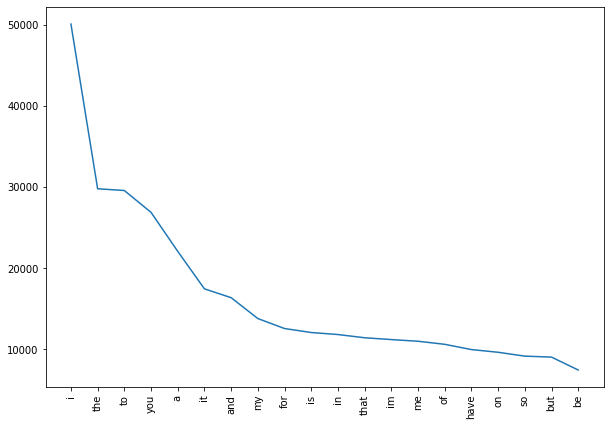

In [31]:
plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in unigrams])
my_xticks = [i[0] for i in unigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.show()

In [32]:
with open(BI_FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
bigrams = freq_dist.most_common(20)
bigrams

[(('i', 'have'), 2444),
 (('in', 'the'), 2376),
 (('i', 'was'), 2272),
 (('for', 'the'), 2167),
 (('i', 'dont'), 2075),
 (('i', 'am'), 2051),
 (('have', 'a'), 1924),
 (('but', 'i'), 1904),
 (('i', 'love'), 1880),
 (('i', 'know'), 1871),
 (('on', 'the'), 1743),
 (('to', 'be'), 1696),
 (('have', 'to'), 1684),
 (('i', 'think'), 1683),
 (('and', 'i'), 1617),
 (('going', 'to'), 1588),
 (('i', 'cant'), 1587),
 (('it', 'was'), 1536),
 (('of', 'the'), 1458),
 (('thanks', 'for'), 1380)]

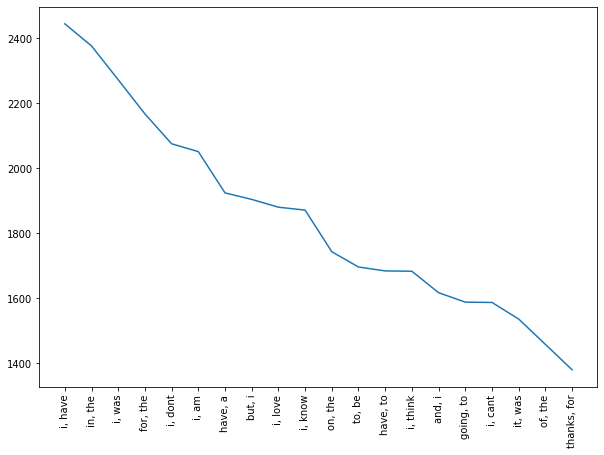

In [33]:
plt.figure(1, [10, 7])
x = np.array(range(0, 40, 2))
y = np.array([i[1] for i in bigrams])
my_xticks = [', '.join(i[0]) for i in bigrams]
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)
plt.show()

In [34]:

with open(FREQ_DIST_FILE, 'rb') as pkl_file:
    freq_dist = pickle.load(pkl_file)
unigrams = freq_dist.most_common(100)
log_ranks = np.log(range(1, 101))
log_freqs = np.log([i[1] for i in unigrams])
z = np.polyfit(log_ranks, log_freqs, 1)
p = np.poly1d(z)
p

poly1d([-0.76616898, 11.18567654])

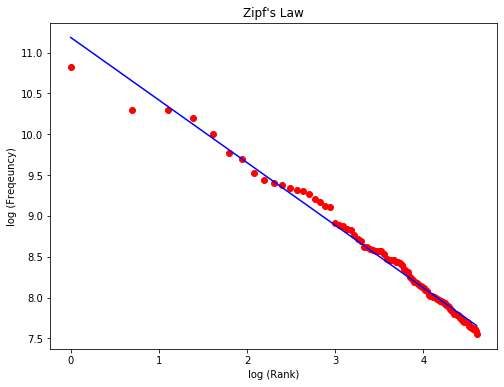

In [35]:
plt.figure(3, [8,6])
plt.plot(log_ranks, log_freqs, 'ro')
plt.plot(log_ranks,p(log_ranks),'b-')
plt.xlabel('log (Rank)')
plt.ylabel('log (Freqeuncy)')
plt.title('Zipf\'s Law')
plt.show()

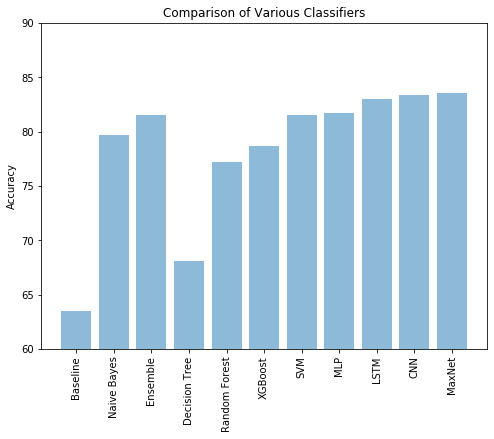

In [3]:
classifiers = ['Baseline', 'Naive Bayes', 'Ensemble', 'Decision Tree', 'Random Forest', 'XGBoost', 'SVM', 'MLP', 'LSTM', 'CNN', 'MaxNet']
accuracies = [63.48, 79.68, 81.52, 68.1, 77.21, 78.72, 81.55, 81.7, 83.00, 83.34, 83.58]
plt.figure(4, [8,6])
plt.bar(range(len(classifiers)), accuracies, align='center', alpha=0.5)
plt.xticks(range(len(classifiers)), classifiers, rotation=90)
plt.ylabel('Accuracy')
plt.title('Comparison of Various Classifiers')
plt.ylim([60, 90])
plt.show()